In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import iris.quickplot as qplt

import numpy
import pandas
import scipy.interpolate

u_file = '/Users/damienirving/Downloads/Data/ua_ERAInterim_500hPa_2006-030day-runmean_native.nc'
v_file = '/Users/damienirving/Downloads/Data/va_ERAInterim_500hPa_2006-030day-runmean_native.nc'
thetao_file ='/Users/damienirving/Downloads/Data/thetao_Omon_ACCESS1-3_historical_r1i1p1_185001-185412.nc'

ticks = numpy.arange(-32, 36, 4)
cmap = 'RdBu_r'

In [9]:
print iris.__version__

1.8.0


## Read and visualise data

In [10]:
date = iris.time.PartialDateTime(year=2006, month=6, day=22)
time_constraint = iris.Constraint(time=date)
level_constraint = iris.Constraint(lev=5)

with iris.FUTURE.context(cell_datetime_objects=True):
    u_cube = iris.load_cube(u_file, 'eastward_wind' & time_constraint)  
    v_cube = iris.load_cube(v_file, 'northward_wind' & time_constraint) 
    #thetao_cube = iris.load_cube(thetao_file, 'sea_water_potential_temperature')

u_cube = u_cube.intersection(longitude=(-180, 180, True, True))
v_cube = v_cube.intersection(longitude=(-180, 180, True, True))
# plots didn't actually change for 0 360 vs -180 180

In [11]:
%matplotlib inline

def plot_winds(u, v):
    """Plot the wind."""

    proj = ccrs.PlateCarree(central_longitude=-180.0)
    fig = plt.figure(figsize=(12, 5))

    ax = plt.subplot(121, projection=proj)
    qplt.contourf(u, levels=ticks, cmap=cmap)
    plt.gca().coastlines()

    ax = plt.subplot(122, projection=proj)
    qplt.contourf(v, levels=ticks, cmap=cmap)
    plt.gca().coastlines()

    iplt.show()

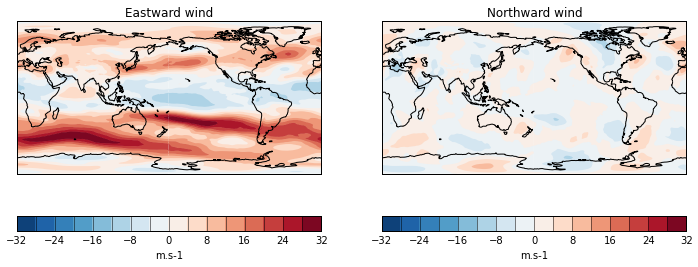

In [12]:
plot_winds(u_cube, v_cube)

## Rotate the wind

In [13]:
rotated_cs = iris.coord_systems.RotatedGeogCS(20, 260)
urot_cube, vrot_cube = iris.analysis.cartography.rotate_winds(u_cube, v_cube, rotated_cs)

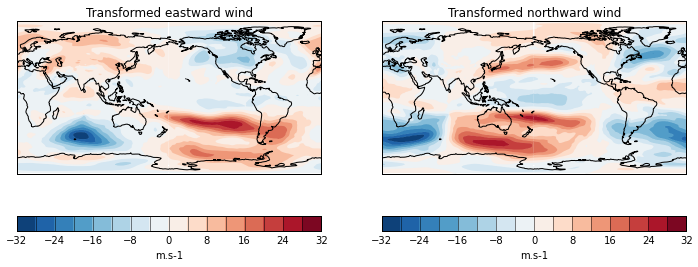

In [14]:
plot_winds(urot_cube, vrot_cube)

In [15]:
print vrot_cube

transformed_northward_wind / (m s**-1) (latitude: 241; longitude: 480)
     Dimension coordinates:
          latitude                              x               -
          longitude                             -               x
     Auxiliary coordinates:
          projection_x_coordinate               x               x
          projection_y_coordinate               x               x
     Scalar coordinates:
          time: 2006-06-22 06:00:00
     Attributes:
          CDI: Climate Data Interface version 1.5.3 (http://code.zmaw.de/projects/cdi...
          CDO: Climate Data Operators version 1.5.3 (http://code.zmaw.de/projects/cdo...
          Conventions: CF-1.0
          history: Mon Jun 15 13:04:23 2015: ncatted -O -a axis,time,c,c,T va_ERAInterim_500hPa_2006-030day-runmean_native.nc
Mon...
          level: 500hPa
          nco_openmp_thread_number: 1


In [205]:
vrot_cube.coords()

[DimCoord(array([-90.  , -89.25, -88.5 , -87.75, -87.  , -86.25, -85.5 , -84.75,
        -84.  , -83.25, -82.5 , -81.75, -81.  , -80.25, -79.5 , -78.75,
        -78.  , -77.25, -76.5 , -75.75, -75.  , -74.25, -73.5 , -72.75,
        -72.  , -71.25, -70.5 , -69.75, -69.  , -68.25, -67.5 , -66.75,
        -66.  , -65.25, -64.5 , -63.75, -63.  , -62.25, -61.5 , -60.75,
        -60.  , -59.25, -58.5 , -57.75, -57.  , -56.25, -55.5 , -54.75,
        -54.  , -53.25, -52.5 , -51.75, -51.  , -50.25, -49.5 , -48.75,
        -48.  , -47.25, -46.5 , -45.75, -45.  , -44.25, -43.5 , -42.75,
        -42.  , -41.25, -40.5 , -39.75, -39.  , -38.25, -37.5 , -36.75,
        -36.  , -35.25, -34.5 , -33.75, -33.  , -32.25, -31.5 , -30.75,
        -30.  , -29.25, -28.5 , -27.75, -27.  , -26.25, -25.5 , -24.75,
        -24.  , -23.25, -22.5 , -21.75, -21.  , -20.25, -19.5 , -18.75,
        -18.  , -17.25, -16.5 , -15.75, -15.  , -14.25, -13.5 , -12.75,
        -12.  , -11.25, -10.5 ,  -9.75,  -9.  ,  -8.25,

In [16]:
x_values = vrot_cube.coord('projection_x_coordinate').points
y_values = vrot_cube.coord('projection_y_coordinate').points
lats = vrot_cube.coord('latitude').points
lons = vrot_cube.coord('longitude').points

print x_values.min(), x_values.max()
print y_values.min(), y_values.max()

-180.0 180.0
-89.6570701505 89.6570701505


In [17]:
x_values_360 = numpy.where(x_values < 0, x_values + 360, x_values)
print x_values_360.min(), x_values_360.max()

1.62904720934e-17 360.0


In [18]:
print lats[10]
print lons[65]

-82.5
-131.25


In [19]:
print 'new lon:', x_values[10, 65]
print 'new lat:', y_values[10, 65]

new lon: 176.006046482
new lat: -13.5465521473


In [20]:
lon_mesh, lat_mesh = numpy.meshgrid(lons, lats)

lat_flat = lat_mesh.flatten()
lon_flat = lon_mesh.flatten()

x_flat = x_values.flatten()
x_flat_360 = x_values_360.flatten()
y_flat = y_values.flatten()

In [21]:
len(lat_flat)

115680

In [22]:
len(x_flat)

115680

In [23]:
def convert_point_1d(orig_lat, orig_lon):
    
    lat_indexes = numpy.where(lat_flat == orig_lat)
    lon_indexes = numpy.where(lon_flat == orig_lon)

    index = numpy.intersect1d(lat_indexes[0], lon_indexes[0])
    assert len(index) == 1
    
    print 'rotated lat (1D method):', y_flat[index]
    print 'rotated lon (1D method):', x_flat[index]
    
def convert_point_2d(orig_lat, orig_lon):
    
    lat_index = numpy.where(lats == orig_lat)
    lon_index = numpy.where(lons == orig_lon)
    
    print 'rotated lat (2D method):', y_values[lat_index, lon_index]
    print 'rotated lon (2D method):', x_values[lat_index, lon_index]

In [24]:
test_lat = 82.5
test_lon = 130.5

convert_point_1d(test_lat, test_lon)
convert_point_2d(test_lat, test_lon)


rotated lat (1D method): [ 15.13393305]
rotated lon (1D method): [ 5.98889898]
rotated lat (2D method): [[ 15.13393305]]
rotated lon (2D method): [[ 5.98889898]]


## Regrid the data

My search path goes from 115E to 225E (or 135W), which means it straddles 180E. To avoid any edge issues, I'm going to want to do the regridding with longitude set from 0 to 360.

In [34]:
points = numpy.column_stack((x_flat_360, y_flat))
values = vrot_cube.data.flatten()

grid_lons, grid_lats = numpy.mgrid[0:360, -90:91]                            
                            

regridded_data = scipy.interpolate.griddata(points, values, (grid_lons, grid_lats), 
                                            method='linear', fill_value=0)

In [35]:
print regridded_data.shape
print values.max(), values.max()
print regridded_data.max(), regridded_data.min()

(360, 181)
26.5006407752 26.5006407752
26.3966097119 -87788.1327376


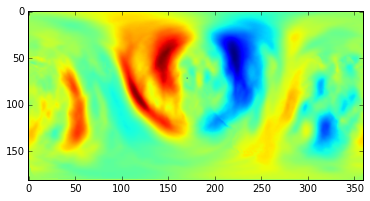

In [36]:
regridded_data_clean = numpy.where(regridded_data < values.min(), values.min(), regridded_data).T 
regridded_data_clean = numpy.where(regridded_data_clean > values.max(), values.max(), regridded_data_clean)

import matplotlib.pyplot
image = matplotlib.pyplot.imshow(regridded_data_clean)
matplotlib.pyplot.show(image)

Not sure why this is upsidedown?

In [37]:
regridded_data_clean.shape

(181, 360)

## Creating a cube from scratch

The documentation is [here](http://scitools.org.uk/iris/docs/latest/iris/iris/cube.html)

In [38]:
from iris.coords import DimCoord
from iris.cube import Cube

latitude = DimCoord(numpy.arange(-90, 91, 1),
                    standard_name='latitude',
                    units='degrees')
longitude = DimCoord(numpy.arange(0, 360, 1),                     
                     standard_name='longitude',
                     units='degrees')
new_cube = Cube(regridded_data_clean,
                dim_coords_and_dims=[(latitude, 0),
                                     (longitude, 1)])

new_cube.long_name = vrot_cube.long_name
new_cube.units = vrot_cube.units

In [39]:
print new_cube

transformed_northward_wind / (m s**-1) (latitude: 181; longitude: 360)
     Dimension coordinates:
          latitude                              x               -
          longitude                             -               x


The transform option (which is part of cartopy) only works properly if the input data have longitude bounds -180 to 180. I've logged [an issue](https://github.com/SciTools/cartopy/issues/644) about this, but in the meantine I need to convert...

In [40]:
new_cube_180 = new_cube.intersection(longitude=(-180, 180, True, True))

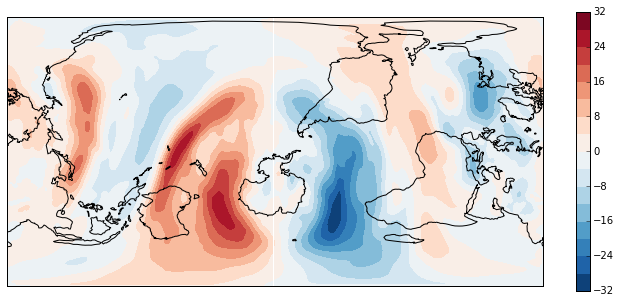

In [45]:
proj_180 = ccrs.RotatedPole(260, 20, central_rotated_longitude=180)
proj_0 = ccrs.RotatedPole(260, 20, central_rotated_longitude=0)
fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(111, projection=proj_180)
x = new_cube_180.coord('longitude').points
y = new_cube_180.coord('latitude').points

ticks = numpy.arange(-32, 36, 4)
cf = ax.contourf(x, y, new_cube_180.data, levels=ticks, cmap=cmap, transform=proj_0)
plt.colorbar(cf)
plt.gca().coastlines()

iplt.show()